In [124]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [125]:
df = pd.read_csv('germany.csv')

In [126]:
def separar_jugadas_2(df):

  team1 = df.teamId.unique()[0]
  team2 = df.teamId.unique()[1]

  #eliminar eventos que no queremos

  df1 = df.drop(df[(df['tag_0'] == 701) | # quitar duelos perdidos. Parece que solo aparecen en los 
                  (df['tag_1'] == 701) |
                  (df['tag_2'] == 701) |
                  (df['tag_3'] == 701) |
                  (df['tag_4'] == 701) |
                  (df['tag_5'] == 701)].index)
  
  df1 = df1.drop(df1[((df1['eventName'] == 'Duel') & (df1['teamId'].shift(-1) == df1['teamId'].shift(1)))].index) #Team - Duel - Team

     
  df1 = df1[(df1['eventName'] != "Save attempt")]

  df1['playId'] = ( ((df1['teamId'] != df1['teamId'].shift(2)) &  ((df1['teamId'] != df1['teamId'].shift(1))) |  #No las cuenta si alguna de las últimas 2 acciones son del otro equipo
                       (df1['eventName'].shift(1) == 'Interruption') | #sumar si el evento pasado es un interruption
                       (df1['matchPeriod'].shift(1) != df1['matchPeriod']) | #Asegura que en la transn 1H-2H se genere nueva jugada 
                       (df1['eventName'] == 'Free Kick') #Asegurar que los tiros libres inicien una nueva jugada
                       )).cumsum()                     

  (df1.loc[
      ((df1['teamId'] != df1['teamId'].shift(1)) & 
       (df1['teamId'] != df1['teamId'].shift(-1))),'playId']) = 0
    
  df['playId'] = (pd.concat((df,df1['playId']),axis=1))['playId'].fillna(0)

  return df

In [127]:
jug_sep = separar_jugadas_2(df) #jug_sep 384412 eventos
jug_sep                         #519407

,Unnamed: 0,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,...,y_inicio,x_fin,y_fin,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,playId
0,0,8,Simple pass,15231,2516739,Pass,2446,1H,2.409746,85.0,...,50,50.0,48.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
1,1,8,Simple pass,14786,2516739,Pass,2446,1H,2.506082,85.0,...,48,22.0,22.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
2,2,8,Simple pass,14803,2516739,Pass,2446,1H,6.946706,85.0,...,22,6.0,46.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
3,3,8,Simple pass,14768,2516739,Pass,2446,1H,10.786491,85.0,...,46,20.0,10.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
4,4,8,Simple pass,14803,2516739,Pass,2446,1H,12.684514,85.0,...,10,27.0,4.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519402,519402,1,Ground attacking duel,15317,2517044,Duel,2463,2H,2825.097992,11.0,...,9,90.0,6.0,702.0,1801.0,NaN,NaN,NaN,NaN,0.0
519403,519403,1,Ground defending duel,14804,2517044,Duel,2451,2H,2825.519102,12.0,...,94,0.0,95.0,703.0,1801.0,NaN,NaN,NaN,NaN,101089.0
519404,519404,1,Ground attacking duel,15317,2517044,Duel,2463,2H,2826.053788,11.0,...,6,100.0,5.0,701.0,1802.0,NaN,NaN,NaN,NaN,0.0
519405,519405,8,Simple pass,14804,2517044,Pass,2451,2H,2828.080925,85.0,...,95,5.0,93.0,1802.0,NaN,NaN,NaN,NaN,NaN,101089.0


# verificar que los tiros están del mismo lado

,Unnamed: 0,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,...,x_inicio,y_inicio,y_fin,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,playId
x_fin,,,,,,,,,,,,,,,,,,,,,
0.0,3829,3829,3829,3829,3829,3829,3829,3829,3829,3829,...,3829,3829,3829,3829,3829,3829,2813,581,37,3829
100.0,3069,3069,3069,3069,3069,3069,3069,3069,3069,3069,...,3069,3069,3069,3069,3069,3069,2231,448,31,3069


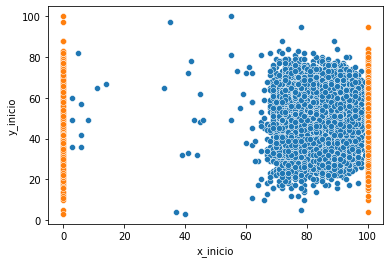

In [128]:
# ver los tiros

tiros = df[df['eventName'] == 'Shot']

sns.scatterplot(data=tiros, x="x_inicio", y="y_inicio")
sns.scatterplot(data=tiros, x="x_fin", y="y_inicio") #pensar que hacer con los tiros. (co x_fin)

tiros.groupby(['x_fin']).count()


## conseguir goles

- solo nos importan las jugadas que terminan en goles.
- no nos interesan autogoles, penales o jugadas a balón parado

In [146]:
#ver goles
#def plays_w_goals()
tiros
#fuentes dicen que en 2017-2018 se metieron 855 goles
goles = jug_sep[(jug_sep['tag_0'] == 101) | 
                  (jug_sep['tag_1'] == 101) |
                  (jug_sep['tag_2'] == 101) |
                  (jug_sep['tag_3'] == 101) |
                  (jug_sep['tag_4'] == 101) |
                  (jug_sep['tag_5'] == 101) |
                  (jug_sep['tag_0'] == 102) | 
                  (jug_sep['tag_1'] == 102) |
                  (jug_sep['tag_2'] == 102) |
                  (jug_sep['tag_3'] == 102) |
                  (jug_sep['tag_4'] == 102) |
                  (jug_sep['tag_5'] == 102)]

goles = goles[(goles['eventName'] == 'Shot') |
     (goles['eventName'] == 'Free Kick') | #con penales se llega a 833
     (goles['eventName'] == 'Pass') |  #con pases se llega a 834 (fue un autogol)
     (goles['eventName'] == 'Others on the ball')] # con others on the ball se llega a los 855

#eventos que estpan involucrados en goles: Shot, Save attempt, Free Kick, Pass, Others on the ball

jug_goles = goles[(goles['playId'] != 0) &
                  (goles['eventName'] != "Free Kick") &
                  (goles['eventName'] != "Pass") &
                  (goles['eventName'] != "Others on the ball")
                  
                 ].copy()

jug_goles['is_goal'] = 1 #son 675 goles los que nos interesan.  de los 6898 tiros. como el 10 %


#modificar is_shot para que solo sea 1 o 0. 
jug_goles = jug_goles.groupby(['playId'], as_index=False).sum()[['playId', 'is_goal']].sort_values(by=['is_goal']) # la jugada 81066 tiene 2 goles

#jug_sep[jug_sep['playId'] == 81066] #arreglar después
#events_w_shot

jug_goles2 = pd.merge(jug_sep2, jug_goles, how="left", on=["playId"])
jug_goles2 = jug_goles2[jug_goles2['y'] == 1] #todos los eventos de jugadas que terminan en tiros



In [130]:

# preparar datos para reresión logística

#tirar los eventos con play_id=0
jug_sep_ = jug_sep[jug_sep['playId'] != 0].copy()

#hay 6898 eventos que terminan en tiros, 512509 eventos NO terminan en tiro
#
jug_sep_.loc[jug_sep['eventName'] == 'Shot', 'is_shot'] = 1
jug_sep_['is_shot'] = jug_sep_['is_shot'].fillna(0)

#hay jugadas que tienen más de un tiro. De un total de 93544 jugadas
# 3 jugadas tienen 3.   78044,26233,35201
# 170 jugadas tienen 2


#modificar is_shot para que solo sea 1 o 0. 
jugadas = jug_sep_.groupby(['playId'], as_index=False).sum()[['playId', 'is_shot']]
jugadas['is_shot'] = jugadas['is_shot'].mask(jugadas['is_shot'] > 1, other=1)  #solo confirmar que si es el mismo número de registros que si son tiros
jugadas = jugadas.rename(columns={"is_shot": "play_w_shot"})

jugadas.sort_values(by=['play_w_shot'], ascending = False)


,playId,play_w_shot
48391,52341.0,1.0
7720,8326.0,1.0
41676,45099.0,1.0
86318,93314.0,1.0
41681,45104.0,1.0
...,...,...
32288,34939.0,0.0
32287,34938.0,0.0
32286,34937.0,0.0
32285,34936.0,0.0


In [131]:

#join con los eventos, by playId
jug_sep2 = pd.merge(jug_sep, jugadas, how="left", on=["playId"])
#407655
jug_sep2 = jug_sep2.rename(columns={"play_w_shot": "y"})
#ver porque se pasa a 384412 eventos

#### Data final corresponde a los eventos que corresponden a jugadas y se predice cuales terminan en tiros
#### Datafinal2 corresponde a los eventos de jugadas que terminan en tiros y terminan en gol.

In [145]:


data_final = jug_sep2[['x_inicio','y_inicio','y_fin','y']]

data_final = data_final.dropna() # hay registros que no tienen coordenadas registradas
#vale la pena ver que eventos son y si hay una razón 

data_final #384324 ya sin registros vacíos, 384412 originalmente

,x_inicio,y_inicio,y_fin,y
0,50,50,48.0,0.0
1,50,48,22.0,0.0
2,22,22,46.0,0.0
3,6,46,10.0,0.0
4,20,10,4.0,0.0
...,...,...,...,...
519396,78,53,46.0,1.0
519397,83,46,100.0,1.0
519398,17,53,60.0,0.0
519403,10,94,95.0,0.0


In [216]:
data_final_2 = jug_goles2.drop('y',1)

data_final_2 = data_final_2[['x_inicio','y_inicio','y_fin','is_goal']]
data_final_2['is_goal'] = data_final_2['is_goal'].fillna(0)
data_final_2 = data_final_2.rename(columns={"is_goal": "y"})
data_final_2 = data_final_2.dropna() # hay 2 registros que no tienen coordenadas registradas

#prueba con menos datos
temp1 = data_final_2[data_final_2['y'] == 1]#4204 eventos fueron involucrados en gol. de los 34938 eventos que estuvieron en tiros. 
temp2 = data_final_2[data_final_2['y'] == 0].head(4500)

data_final_2 = pd.concat([temp1,temp2])

C:\Users\Ernie\AppData\Local\Temp\ipykernel_12436\4197177135.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_final_2 = jug_goles2.drop('y',1)


,x_inicio,y_inicio,y_fin,y
177,79,15,59.0,1.0
178,95,59,0.0,1.0
348,89,34,53.0,1.0
349,98,53,0.0,1.0
1130,23,73,29.0,1.0
...,...,...,...,...
66650,18,12,10.0,0.0
66651,44,10,19.0,0.0
66652,36,19,26.0,0.0
66653,29,26,20.0,0.0


In [133]:
#over sampling, no se terminó usando

x = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = x_train.columns

In [134]:
logisticRegr = LogisticRegression()

In [135]:
logisticRegr.fit(x_train, y_train)

C:\Users\Ernie\anaconda3\envs\sport_analysis\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [136]:
#logisticRegr.predict(x_test[0])
predictions = logisticRegr.predict(x_test)

In [137]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.9106836198372912


In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [139]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[105000      0]
 [ 10298      0]]


# conclsusión 1
- parece que el modelo de eventos para predecir si es tiro no parece ser tan prometedor.
- al menos si se usan solo las coordenadas

# prueba 2: modelo para ver que eventos terminan en gol (de tiros)

<AxesSubplot:xlabel='x_inicio', ylabel='y_inicio'>

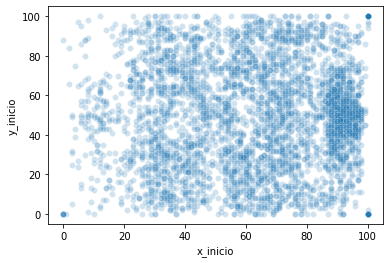

In [212]:
no_gol = data_final_2[data_final_2['y'] == 0]
yes_gol = data_final_2[data_final_2['y'] == 1]

#sns.scatterplot(data=no_gol, x="x_inicio", y="y_inicio", alpha=0.2)
sns.scatterplot(data=yes_gol, x="x_inicio", y="y_inicio", alpha = 0.2)
#sns.scatterplot(data=data_final_2, x="x_fin", y="y_inicio")

In [227]:
x2 = data_final_2.loc[:, data_final_2.columns != 'y']
y2 = data_final_2.loc[:, data_final_2.columns == 'y']

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3, random_state=0)
columns = x_train.columns

In [228]:
logisticRegr = LogisticRegression()#ver impacto de max_iter

In [229]:
logisticRegr.fit(x_train2, y_train2.values.ravel()) 



LogisticRegression()

In [230]:
predictions2 = logisticRegr.predict(x_test2)

In [231]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.4729396867248348


In [232]:
cm = metrics.confusion_matrix(y_test2, predictions2)
print(cm)

[[1054  292]
 [ 892  374]]


# Conclusión 2

- ver que tan importante que los datos estén balanceados (ver que tal con la prueba 1)
- con los datos originales 

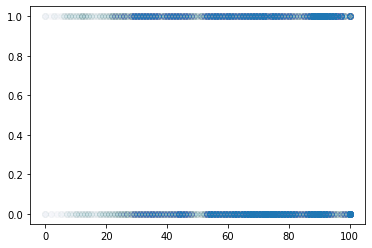

In [238]:
plt.scatter(data_final_2['x_inicio'], data_final_2['y'], alpha=0.006)

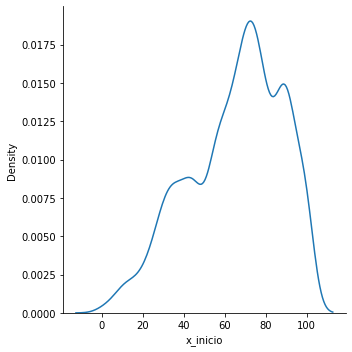

In [240]:
sns.displot(no_gol, x="x_inicio", kind="kde")

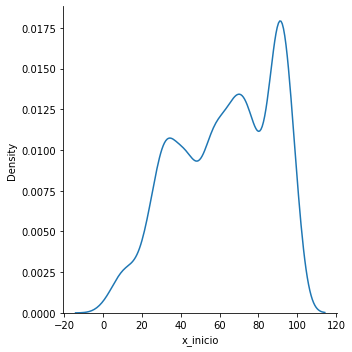

In [241]:
sns.displot(yes_gol, x="x_inicio", kind="kde")

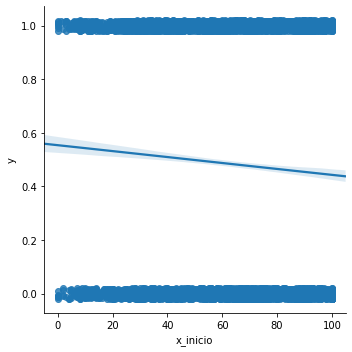

In [252]:
sns.lmplot(x="x_inicio", y="y", data=data_final_2,
                y_jitter=.02, logistic=True, truncate=False)

<AxesSubplot:xlabel='x_inicio', ylabel='y'>

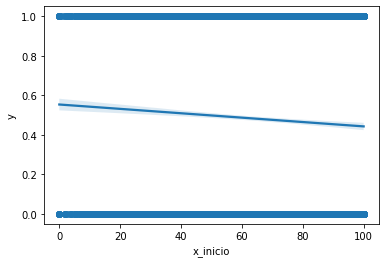

In [279]:
sns.regplot(x='x_inicio', y='y', data=data_final_2, logistic=True)

In [258]:
import statsmodels.api as sm

logit_model=sm.Logit(y_train2,x_train2)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.691649
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6092
Model:                          Logit   Df Residuals:                     6089
Method:                           MLE   Df Model:                            2
Date:                Sat, 02 Jul 2022   Pseudo R-squ.:                0.001255
Time:                        17:49:49   Log-Likelihood:                -4213.5
converged:                       True   LL-Null:                       -4218.8
Covariance Type:            nonrobust   LLR p-value:                  0.005013
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_inicio      -0.0025      0.001     -3.633      0.000      -0.004      -0.001
y_inicio       0.0008      0.

In [277]:
yhat = result.predict(x_test2)
prediction = list(map(round, yhat))


from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
  
# confusion matrix
cm = confusion_matrix(y_test2, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test2, prediction))

Confusion Matrix : 
 [[1181  165]
 [1037  229]]
Test accuracy =  0.5398162327718223


In [ ]:
sm.graphics.plot_partregress('Lottery', 'Wealth', ['Region', 'Literacy'], data=data_final_2, obs_labels=False)

In [263]:
from sklearn import linear_model
from scipy.special import expit
 
#model = linear_model.LogisticRegression(C=1e5, solver='lbfgs')
#model.fit(iris_data[:,0].reshape(-1,1), iris_target)

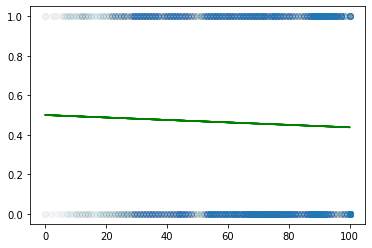

In [269]:
coef_ = -0.0025
intercept_ = 0.001

y_test = x_test * coef_ + intercept_
 
sigmoid = expit(y_test)
#sigmoid = sigmoid['x_inicio']

plt.scatter(data_final_2['x_inicio'], data_final_2['y'], alpha=0.006)

plt.plot(x_test,sigmoid,c="green", label = "logistic fit")